In [1]:
import numpy as np
import scipy 
from sympy import *
import pylab as plt
import math
from sympy.physics.wigner import gaunt
from scipy.integrate import odeint
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
#Universal Constants
h = 6.6260715e-34 #m^2 kg / s
hbar = h/(2*np.pi)
c = 2.99792458e8 #m/s
kb = 1.380649e-23 #Joules per Kelvin

In [3]:
def Silvera_Triplet(R):
    conv = 5.06e-4
    x = R / conv / 4.16 
    D = 1.28
    K2eV = 8.61732814974056e-5
    F=(x>D)+(x<D)*np.exp(-(D/x-1)**2)
    return 6.46 * K2eV * (4.889e4*np.exp(0.0968-8.6403*x-2.427*x**2)-(1.365/x**6+0.425/x**8+0.183/x**10)*F)

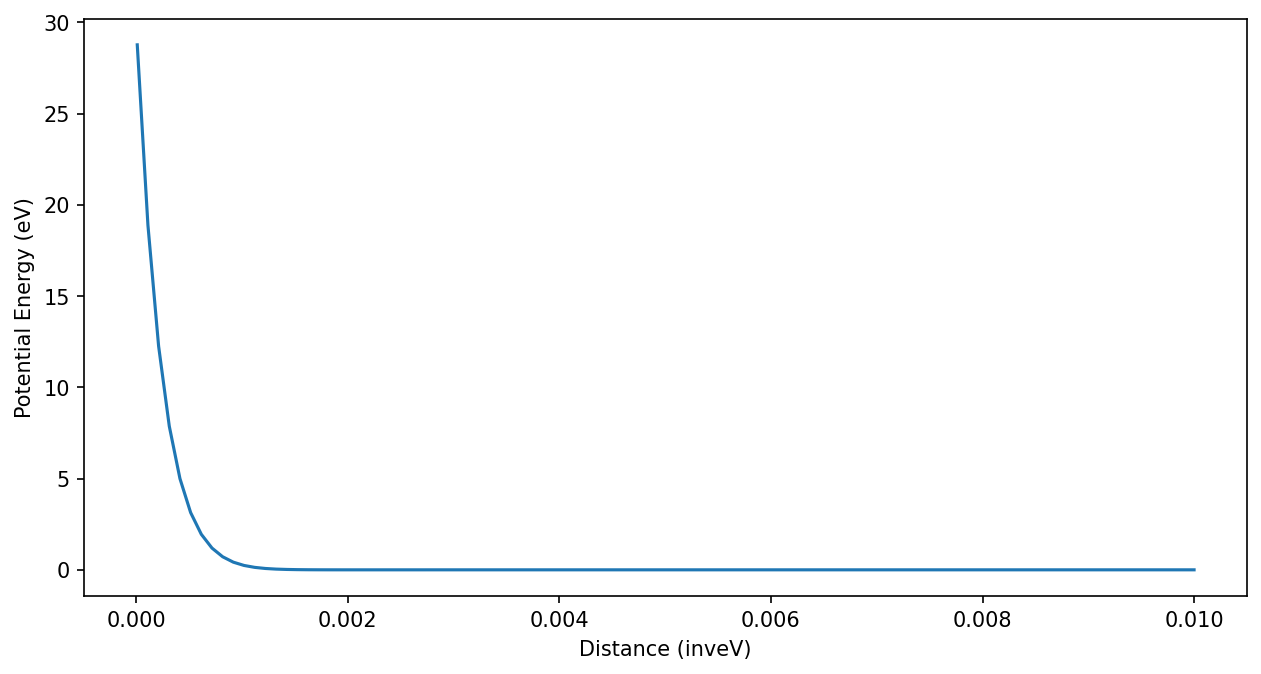

In [4]:
Rhos = np.linspace(1e-5, 1e-2, 100)
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(Rhos, Silvera_Triplet(Rhos))
plt.xlabel("Distance (inveV)")
plt.ylabel("Potential Energy (eV)")
plt.show()

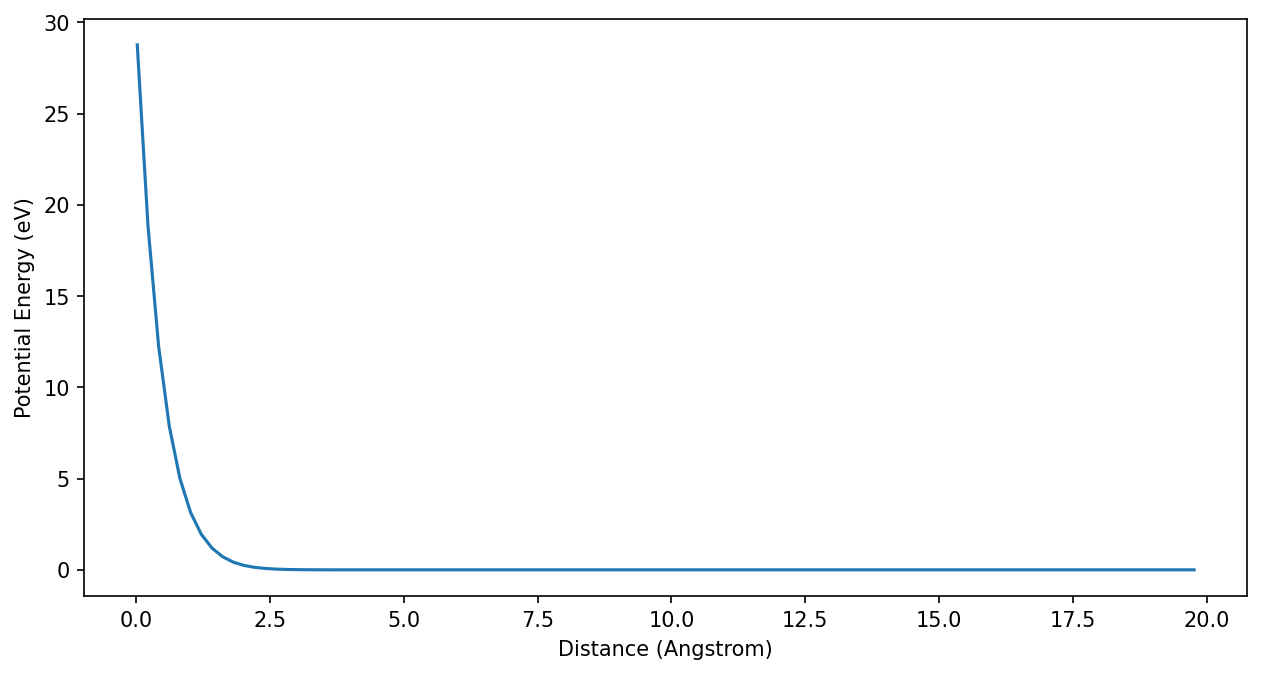

In [5]:
conv = 5.06e-4
Rhos = np.linspace(1e-5, 1e-2, 100)
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(Rhos/conv, Silvera_Triplet(Rhos))
plt.xlabel("Distance (Angstrom)")
plt.ylabel("Potential Energy (eV)")
plt.show()

In [6]:
def p_of_temp(mass, T):
    mu = mass/2
    J2eV = 6.242e18
    return np.sqrt(2 * mu * kb * J2eV * T)
 
def pprime(pin, epsa, epsb, epsprimea, epsprimeb, mass):
    mu = mass/2
    E = pin**2 / (2 * mu)
    Eprime = E + epsa + epsb - epsprimea - epsprimeb
    pprime = np.sqrt(2 * mu * Eprime)
    return pprime

In [7]:
def ddx(y, rho, mass, Potential, l, pin):
    mu = mass/2
    
    u = y[0]
    v = y[1]
    dudr = v
    dvdr = (-pin**2 + 2 * mu * Potential(rho) + l * (l + 1) / (rho**2)) * u
    return [dudr,dvdr]
    
def Wave_Function(pin, l, bigrho, r0, function, mass, version, int_type):
    rhos = np.linspace(r0, bigrho, 20000)
    init = [r0,1]
    def ddxToint(rhos, y):
        return function(y, rhos, mass, Silvera_Triplet, l, pin)
    State = scipy.integrate.solve_ivp(ddxToint, (rhos[0] ,rhos[-1]), init, t_eval=rhos, method = int_type)
    Normalization = np.sqrt(State.y[0]**2 + (State.y[1]/pin)**2)
    return State.y[0]/Normalization[-1]

def GetIntegral (alphain, betain, alphaout, betaout, mass, A, r0, temp , how_to_int):
    rhos = np.linspace(r0, A, 20000)

    P1 = p_of_temp(mass, temp)
    P2 = pprime(P1, alphain, betain, alphaout, betaout, mass)
    
    InState = np.array(Wave_Function(P1, 0, A, r0, ddx, mass, Silvera_Triplet, how_to_int))
    OutState = np.array(Wave_Function(P2, 2, A, r0, ddx, mass, Silvera_Triplet, how_to_int))

    Integrand = interp1d(rhos, InState * OutState / rhos**3, kind = 'linear')


    if A <= 250:
        Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
    else:
        Integral1 = quad(Integrand,rhos[0],250)[0]/(P1*P2)
        Integral2 = quad(Integrand,250,rhos[-1])[0]/(P1*P2)

        Integral = Integral1 + Integral2

    return Integral

In [8]:
B_Values = np.logspace(-3,1,30)

In [9]:
def GetHyperFineLevels(pm, mf, delW, mN, gI):
    gL = 1 #Orbital g-factor
    gS = 2 #Electron spin g-factor
    L = 0 #Orbital Angular Momentum
    S = .5 #Electron spin
    I = .5 #Nuclear spin
    J = .5 #Total Angular Momentum
    ge = 2.002319 #Electron g-factor
    meeV = .511e6 #mass of electron
    mue = 9.27e-24 #magnetic moment of electron
    muN = mue*meeV/(mN*1e9) #magnetic moment of nucleus
    J2eV = 6.242e18
    
    gJ = gL * (J * (J + 1) + L * (L + 1) - S * (S + 1)) / (2 * J * (J + 1)) + ge * (J * (J + 1) - L * (L +1) + S * (S + 1)) / (2 * J *(J + 1))

    x = B_Values * (gJ * mue - gI * muN) / (h * delW)
    Term1 = -h * delW / (2 * (2 * I + 1)) * np.ones_like(B_Values)
    Term2 = muN * gI * mf * B_Values

    if(abs(mf)==abs(I + .5)):
        sgn = mf / (I + .5)
        Term3 = h*delW / 2 * (1 + sgn*x)
    else:
        Term3 = pm * h * delW / 2 * np.sqrt(1 + 2 * mf * x / (I + .5) + x**2)

    delE = (Term1 + Term2 + Term3) / h

    return delE * h * J2eV

def AllHFLevels(delW, mN, gI): 
    delEs = []
    for pm in [-1,1]:
        F = .5 + pm/2
        for mF in np.arange(-F, F+1, 1):
            delEs.append(GetHyperFineLevels(pm, mF, delW, mN, gI))
    delEs = np.array(delEs)
    delEs = np.sort(delEs, axis = 0)
    delEDict={}
    for i in range(0,4):
        letter = chr(97 + i)
        delEDict[letter]=delEs[i]
    return delEDict

In [10]:
delWH = 1.4204057517667e9 #Hyperfine of hydrogen splitting constant in Hz
delWT = 1.516701396e9
gIH = 5.585694702 # Hydrogen nuclear g-factor
gIT = 5.95792492 
mH = 1.00784 #Mass of hydrogen in Dalton
mT = 3.01604928 

HLevels = AllHFLevels(delWH, mH, gIH)
TLevels = AllHFLevels(delWT, mT, gIT)
letters = ['a', 'c', 'd']

In [11]:
Hm = 938.78e6 #Mass of hydrogen in eV/c^2
Tm = 2808.9261e6
Hmu = Hm/2
Tmu = Tm/2

HaaSpatials = []
HacSpatials = []
HadSpatials = []
HccSpatials = []
HcdSpatials = []
TaaSpatials = []
TacSpatials = []
TadSpatials = []
TccSpatials = []
TcdSpatials = []

i = 0 
for b in B_Values:
    aH = HLevels['a'][i] 
    cH = HLevels['c'][i] 
    dH = HLevels['d'][i] 
    
    aT = TLevels['a'][i] 
    cT = TLevels['c'][i] 
    dT = TLevels['d'][i] 

    r0 = .000000001
    temp = 1e-4
    intlimit = .1

    PH = p_of_temp(Hm , temp)
    PT = p_of_temp(Tm , temp)
    
    PoutHaa = pprime(PH, dH, dH, aH, aH, Hmu)
    PoutHac = pprime(PH, dH, dH, aH, cH, Hmu)
    PoutHad = pprime(PH, dH, dH, aH, dH, Hmu)
    PoutHcc = pprime(PH, dH, dH, cH, cH, Hmu)
    PoutHcd = pprime(PH, dH, dH, cH, dH, Hmu)
    
    PoutTaa = pprime(PT, dT, dT, aT, aT, Tmu)
    PoutTac = pprime(PT, dT, dT, aT, cT, Tmu)
    PoutTad = pprime(PT, dT, dT, aT, dT, Tmu)
    PoutTcc = pprime(PT, dT, dT, cT, cT, Tmu)
    PoutTcd = pprime(PT, dT, dT, cT, dT, Tmu)  

    IntegralHac = GetIntegral(dH, dH, aH, cH, Hmu, intlimit, r0, temp, 'Radau')
    IntegralHad = GetIntegral(dH, dH, aH, dH, Hmu, intlimit, r0, temp, 'Radau')
    IntegralHcc = GetIntegral(dH, dH, cH, cH, Hmu, intlimit, r0, temp, 'Radau')
    IntegralHcd = GetIntegral(dH, dH, cH, dH, Hmu, intlimit, r0, temp, 'Radau')

    IntegralTac = GetIntegral(dT, dT, aT, cT, Tmu, intlimit, r0, temp, 'Radau')
    IntegralTad = GetIntegral(dT, dT, aT, dT, Tmu, intlimit, r0, temp, 'Radau')
    IntegralTcc = GetIntegral(dT, dT, cT, cT, Tmu, intlimit, r0, temp, 'Radau')
    IntegralTcd = GetIntegral(dT, dT, cT, dT, Tmu, intlimit, r0, temp, 'Radau')

    if b <= 8.5:
        IntegralHaa = GetIntegral(dH, dH, aH, aH, Hmu, intlimit, r0, temp, 'Radau')
        IntegralTaa = GetIntegral(dT, dT, aT, aT, Tmu, intlimit, r0, temp, 'Radau')
        
    else:
        IntegralHaa = GetIntegral(dH, dH, aH, aH, Hmu, intlimit, r0, temp, 'RK45')
        IntegralTaa = GetIntegral(dT, dT, aT, aT, Tmu, intlimit, r0, temp, 'RK45')

    HaaSpatials.append(PoutHaa * Hmu * IntegralHaa**2)
    HacSpatials.append(PoutHac * Hmu * IntegralHac**2)
    HadSpatials.append(PoutHad * Hmu * IntegralHad**2)
    HccSpatials.append(PoutHcc * Hmu * IntegralHcc**2)
    HcdSpatials.append(PoutHcd * Hmu * IntegralHcd**2)

    TaaSpatials.append(PoutTaa * Tmu * IntegralTaa**2)
    TacSpatials.append(PoutTac * Tmu * IntegralTac**2)
    TadSpatials.append(PoutTad * Tmu * IntegralTad**2)
    TccSpatials.append(PoutTcc * Tmu * IntegralTcc**2)
    TcdSpatials.append(PoutTcd * Tmu * IntegralTcd**2)

    i = i + 1   

HaaSpatials = np.array(HaaSpatials) 
HacSpatials = np.array(HacSpatials) 
HadSpatials = np.array(HadSpatials) 
HccSpatials = np.array(HccSpatials) 
HcdSpatials = np.array(HcdSpatials) 
TaaSpatials = np.array(TaaSpatials) 
TacSpatials = np.array(TacSpatials) 
TadSpatials = np.array(TadSpatials) 
TccSpatials = np.array(TccSpatials) 
TcdSpatials = np.array(TcdSpatials) 

/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_13090/3090042800.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)
/var/folders/zl/6mjpyqs158s3ql94pwj2jgd40000gn/T/ipykernel_13090/3090042800.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Integral = quad(Integrand,rhos[0],rhos[-1])[0]/(P1*P2)


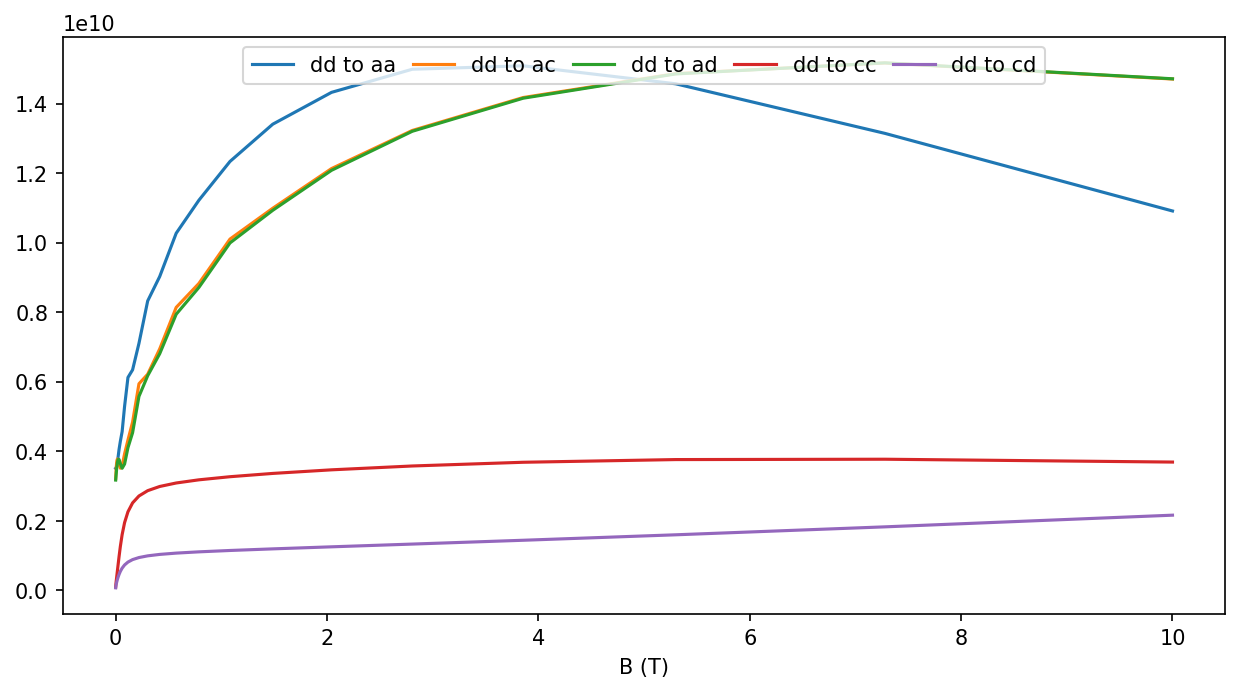

In [12]:
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(B_Values, HaaSpatials, label="dd to aa")
plt.plot(B_Values, HacSpatials, label="dd to ac")
plt.plot(B_Values, HadSpatials, label="dd to ad")
plt.plot(B_Values, HccSpatials, label="dd to cc")
plt.plot(B_Values, HcdSpatials, label="dd to cd")
plt.xlabel("B (T)")
plt.legend(loc='upper center', fontsize=10, ncol=14, columnspacing=0.8)
plt.show()

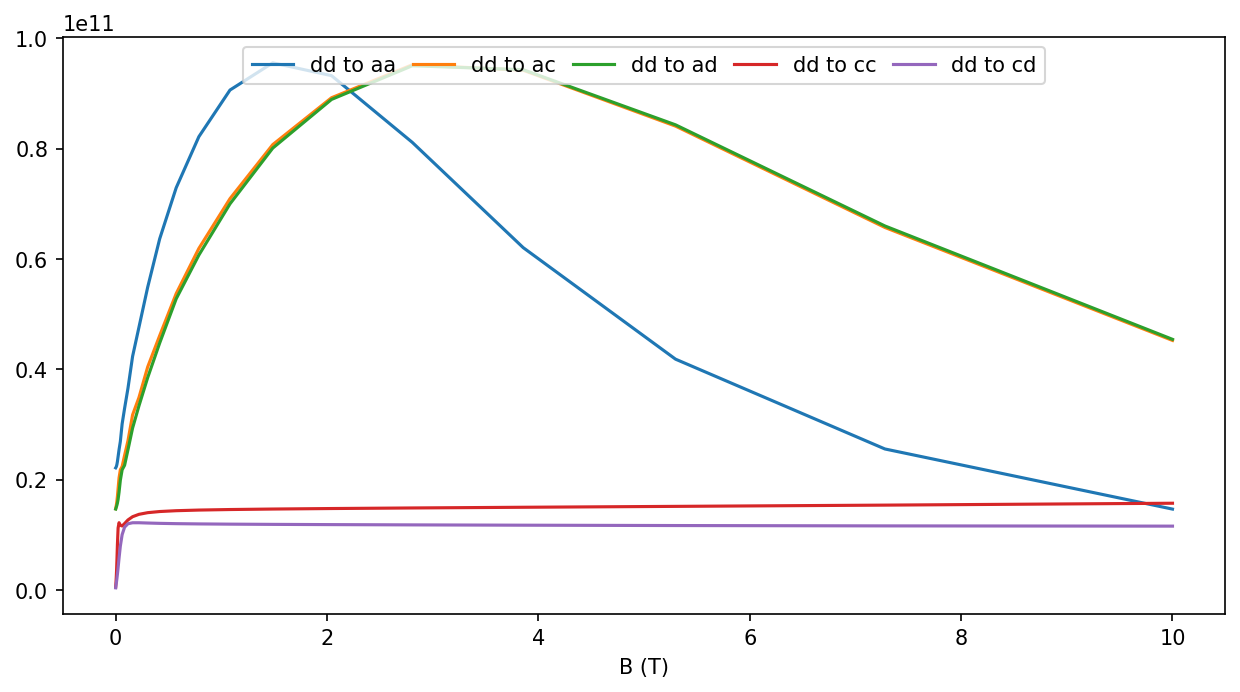

In [13]:
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(B_Values, TaaSpatials, label="dd to aa")
plt.plot(B_Values, TacSpatials, label="dd to ac")
plt.plot(B_Values, TadSpatials, label="dd to ad")
plt.plot(B_Values, TccSpatials, label="dd to cc")
plt.plot(B_Values, TcdSpatials, label="dd to cd")
plt.xlabel("B (T)")
plt.legend(loc='upper center', fontsize=10, ncol=14, columnspacing=0.8)
plt.show()

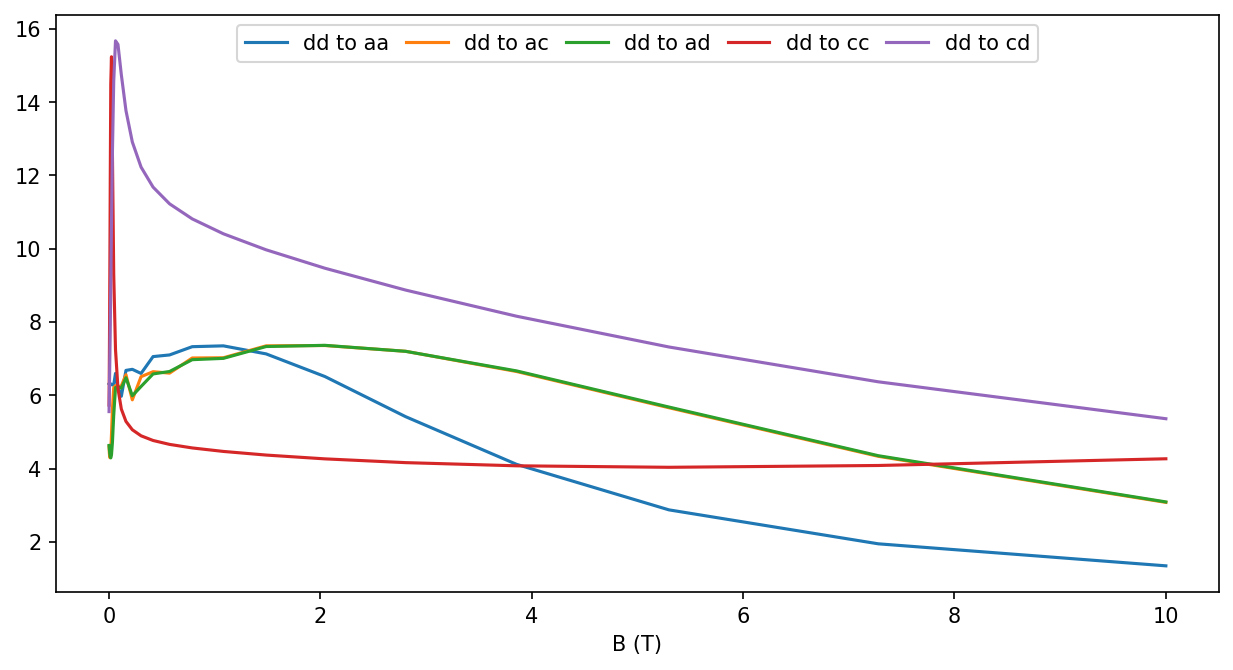

In [14]:
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(B_Values, TaaSpatials / HaaSpatials, label="dd to aa")
plt.plot(B_Values, TacSpatials / HacSpatials, label="dd to ac")
plt.plot(B_Values, TadSpatials / HadSpatials, label="dd to ad")
plt.plot(B_Values, TccSpatials / HccSpatials, label="dd to cc")
plt.plot(B_Values, TcdSpatials / HcdSpatials, label="dd to cd")
plt.xlabel("B (T)")
plt.legend(loc='upper center', fontsize=10, ncol=14, columnspacing=0.8)
plt.show()